### Import library

In [35]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
from sklearn import tree
from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import KFold
from datetime import datetime as dt
# import seaborn as sns
from IPython.core.display import Image

def create_traindata(given_data, test_idx, N, from_idx):
    data = [separate_list(d,test_idx[0], test_idx[1], from_idx) for d in given_data] 
    data_test = [d[0] for d in data] 
    data_train = [d[1] for d in data]

    true_data = data_test[0]

    train_label = data_train[0]
    train_data = [data_train[i] for i in range(1,N)]
    test_data = [data_test[i] for i in range(1,N)]    
    return train_data, train_label, test_data, true_data

def comp_plot(true_data, estimated_data, title='Title'):
    plt.figure(figsize=(10, 9))
    plt.grid()
    plt.title(title, fontsize=30)
    plt.ylim(0,1400)
    plt.xlim(0,17)
    plt.tick_params(labelsize=20)
    plt.hold(True);
    plt.plot(true_data,label="Observed irradiance",lw=1, color='gray')
    plt.plot(estimated_data, '-s', markevery=3, label="Estimated irradiance", lw=1, color='black')
    plt.legend(fontsize=20,frameon=False,loc='upper center')
    plt.ylabel(r'Solar irradiance [$kWm^{-2}$]', fontsize=30)
    plt.xlabel('Local time (UTC+9)', fontsize=30)
    plt.savefig(title+"_plot.png", dpi=250)

def comp_plot2(dataset, days, title='Title'):
    plt.figure(figsize=(10,10))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)
    fs = 20;
    for i in range(0,len(test_idx)):        
        plt.subplot(2,2,i+1)
        plt.title(title, fontsize=fs)
        plt.ylim(0,1400)
        plt.xlim(0,1400)
        plt.tick_params(labelsize=fs)
        plt.hold(True);
        plt.plot(dataset[i]['true_data'],label="Ground obs. H",lw=2, color='lightgray')
        plt.plot(dataset[i]['estimated'], '--', label="Estimated H", lw=2, color='black')
        plt.grid(True)
        plt.title(title+'  2015/4/'+str(days[i]), fontsize=fs)
        plt.xticks([175*0,175*1,175*2,175*3,175*4,175*5,175*6,175*7 ], [0,3,6,9,12,15,18,21,0])
        plt.legend(fontsize=fs-2,frameon=True,loc='upper left')
        plt.ylabel(r'Solar irradiance [$kWm^{-2}$]', fontsize=fs)
        plt.xlabel('Local time (UTC+9)', fontsize=fs)
    plt.savefig(title+'_RF_patterns.png', dpi=250)    
    
    
def comp_scatter(true_data, estimated_data, title='Title'):
    plt.figure(figsize=(10, 9))
    plt.grid()
    plt.title(title, fontsize=30)
    plt.ylim(0,1200)
    plt.xlim(0,1200)
    plt.tick_params(labelsize=20)
    t_est = np.array([1,1200]); t_true = np.array([1,1200]);
    plt.scatter(true_data, estimated_data, alpha=0.7, s=15, color='black')
    plt.plot(t_est,t_true, color='black');
    plt.ylabel(r'Ground measured solar irradiance [$kWm^{-2}$]', fontsize=30)
    plt.xlabel(r'Estimated solar irradiance [$kWm^{-2}$]', fontsize=30)
    plt.title(title, fontsize=30)
    plt.text(100,1100,r'r=%f '%(np.corrcoef((true_data, estimated_data))[0,1]) , fontsize=20)
    np.correlate(t_est,t_true)
    plt.savefig(title+"_scatter.png", dpi=250)
    
import numpy as np
def separate_list(arr, start, end,from_idx):
    if type(arr) is np.ndarray:
        arr_ext = arr[start:end]
        arr_res = np.r_[arr[from_idx:start], arr[end:-1]]
    elif type(arr) is list:
        arr_ext = arr[start:end]    
        arr_res = arr[from_idx:start] + arr[end:-1]
    return [arr_ext, arr_res]    

### Import data
- input data needed
    - obserbed timeseriese data 
    - albedo/tbb timeseriese data

In [36]:
point_name = 'Sapporo'
stlfile = 'data/April/'+point_name+'/'
grmfile = 'data/April/'+point_name+'/'

In [37]:
grmfile

'data/April/Sapporo/'

In [38]:
#files=[grmfile+'ts_H.txt',grmfile+'ts_extH.txt',stlfile+'ts_rhop_B01.txt',stlfile+'ts_rhop_B02.txt',stlfile+'ts_rhop_B03.txt',stlfile+'ts_rhop_B04.txt',stlfile+'ts_rhop_B05.txt', stlfile+'ts_rhop_B06.txt', stlfile+'ts_rhop_B07.txt', stlfile+'ts_rhop_B08.txt', stlfile+'ts_rhop_B09.txt', stlfile+'ts_rhop_B10.txt',stlfile+'ts_rhop_B11.txt',stlfile+'ts_rhop_B12.txt',stlfile+'ts_rhop_B13.txt',stlfile+'ts_rhop_B14.txt',stlfile+'ts_rhop_B15.txt',stlfile+'ts_rhop_B16.txt',grmfile+'ts_extH.txt']

In [61]:
files=[grmfile+'ts_H.txt',grmfile+'ts_extH.txt',stlfile+'ts_rhop_B01.txt',stlfile+'ts_rhop_B02.txt',stlfile+'ts_rhop_B03.txt',stlfile+'ts_rhop_B04.txt',stlfile+'ts_rhop_B05.txt', stlfile+'ts_rhop_B06.txt', stlfile+'ts_rhop_B07.txt', stlfile+'ts_rhop_B08.txt', stlfile+'ts_rhop_B09.txt', stlfile+'ts_rhop_B10.txt',stlfile+'ts_rhop_B11.txt',stlfile+'ts_rhop_B12.txt',stlfile+'ts_rhop_B13.txt',stlfile+'ts_rhop_B14.txt',stlfile+'ts_rhop_B15.txt',stlfile+'ts_rhop_B16.txt']

In [49]:
# load files
data = [np.loadtxt(f,delimiter="\t", skiprows=1, dtype={'names':('Time','Value'),'formats':('S18','f8')}) for f in files]

/Users/ojt_camp01/.pyenv/versions/anaconda3-2.5.0/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


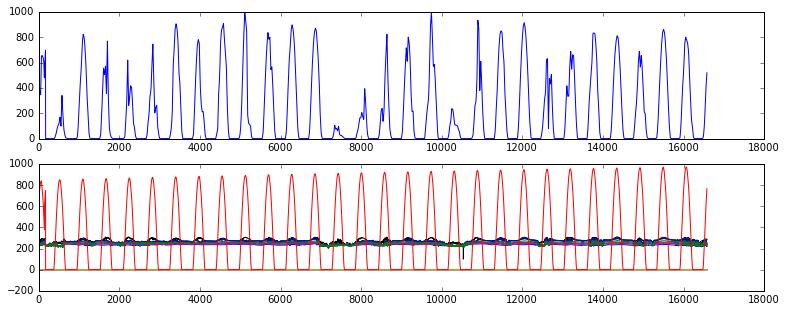

In [41]:
data2 = data
DATA_NUM = len(data)
# plot loaded data
labels = ['B01', 'B02','B05']
plt.figure(figsize=(13, 5))
plt.subplot(2,1,1)
plt.plot(data[0]['Value'],lw=1) # True data
plt.subplot(2,1,2)
[plt.plot(data[i]['Value'], lw=1, ) for i in range(2,DATA_NUM)] # Albedo data
plt.legend()
#plt.xlim(0,100)
plt.savefig("FREAbands.png", dpi=250)

In [62]:
data2[0]['Time']

array([b"'01-Apr-2015 00:02", b"'01-Apr-2015 00:05", b"'01-Apr-2015 00:07",
       ..., b"'30-Apr-2015 23:52", b"'30-Apr-2015 23:55",
       b"'30-Apr-2015 23:57"], 
      dtype='|S18')

In [42]:
from_idx = 40;

In [43]:
# add time column
data = [ d['Value'] for d in data ]

time_data = [dt.strptime(str(d)[3:20], '%d-%b-%Y %H:%M') for d in data2[0]['Time']]
#data.append(np.transpose([d.month for d in time_data]))
data.append(np.transpose([d.day for d in time_data]))
data.append(np.transpose([d.hour for d in time_data]))
data.append(np.transpose([d.minute for d in time_data]))

DATA_NUM = len(data)
#data = data[2500:40000]

In [44]:
[print(np.size(s)) for s in data]


16582
16582
16582
16582
16582
16582
16582
16582
16582
16582
16582
16582
16581
16582
16582
16582
16582
16582
16582
16582
16582
16582


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

### Devide to train data and test data


### 訓練データの作成


#### 各パターンの日時インデックスをセット


In [45]:
test_idx = [[689, 711], [353, 375], [449, 471], [569, 591]]
test_idx

[[689, 711], [353, 375], [449, 471], [569, 591]]

#### パターン A
##### テストデータと訓練データの生成


##### テストデータに対する真のデータの生成


##### 訓練データのラベルとデータへの分離


In [46]:
N = DATA_NUM
dataset = [];
for i in range(0,len(test_idx)):
    ti = test_idx[i]
    [train_data, train_label, test_data, true_data] = create_traindata(data, ti, N, from_idx)
    dict = {'train_data': train_data, 'train_label': train_label, 'test_data':test_data, 'true_data': true_data}
    dataset.append(dict)

ValueError: setting an array element with a sequence.

### Estimation irradiance by Random Forest


In [47]:
N_est = 30
for i in range(0,len(test_idx)):
    estimated = [];
    estimator = RandomForestRegressor()
    model = RandomForestRegressor(n_estimators=N_est,n_jobs=-1)
    model.fit(np.transpose(dataset[i]['train_data']), np.array(dataset[i]['train_label'], dtype=np.float64))
    dataset[i].update({'estimated':model.predict(np.transpose(dataset[i]['test_data']))})

ValueError: setting an array element with a sequence.

In [58]:
i

0

#### 共通


In [ ]:
N_est = 30

In [ ]:
for i in range(0,len(test_idx)):
    estimated = [];
    estimator = RandomForestRegressor()
    model = RandomForestRegressor(n_estimators=N_est,n_jobs=-1)
    model.fit(np.transpose(dataset[i]['train_data']), np.array(dataset[i]['train_label'], dtype=np.float64))
    dataset[i].update({'estimated':model.predict(np.transpose(dataset[i]['test_data']))})

## Result

In [ ]:
days  = [26, 4, 29, 14];
comp_plot2(dataset, days, title='FREA')